# PyTorch Feed-Forward Neural Network

## Dataset: Did it Rain in Seattle? (1948-2017)

Kaggle Dataset Web Link:

https://www.kaggle.com/datasets/rtatman/did-it-rain-in-seattle-19482017

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split, default_collate
import torchmetrics
from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix

import pandas as pd
import os
import pathlib
import matplotlib.pyplot as plt

from sklearn.metrics import classification_report
from sklearn import metrics

# Hyperparameters

In [2]:
# Hyperparameters
input_layer = 4        # Sets the number of input parameters to the input layer
hidden_layer_1 = 7     # Sets the number of output parameters in input layer
hidden_layer_2 = 7     # Sets the number of input parameters to hidden layer 1
hidden_layer_3 = 7     # Sets the number of output parameters in hidden layer 1
hidden_layer_4 = 7     # Sets the number of input parameters to hidden layer 2
hidden_layer_5 = 7     # Sets the number of output parameters in hidden layer 2
hidden_layer_6 = 7     # Sets the number of input parameters to the output layer
output_layer = 1       # Sets the number of output parameters in the output layer
lr = 1e-3              # Sets the leanring rate
epochs = 200           # Sets the number of training epochs
batch_size = 32        # Sets the batch size
# -----------------

# Set the Device to a GPU or CPU

In [3]:
# If a GPU is available use cuda or use the CPU if not available
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Prints out the available processing device to the screen
device

'cpu'

# Random Seed

In [4]:
# Sets the random seed to repeat any randomness
torch.random.manual_seed(1234)

# Load the Training Dataset

In [5]:
# Read in the data as Pandas DataFrames and convert to NumPy arrays
X = pd.read_csv("./output_csv_data/X_train", header=None).values
y = pd.read_csv("./output_csv_data/y_train", header=None).values

# Prints out the features X to the screen
X

array([[-0.33544152,  1.60300718, -0.85914999, -0.49061759],
       [ 0.08653505, -0.50349486,  1.38519235,  1.11730809],
       [-0.56700083, -0.05788866,  0.50348643,  0.42819709],
       ...,
       [-0.98586469,  0.20084116, -0.93930507, -0.37576575],
       [ 0.96188608, -0.05788866, -0.05759915,  0.31334525],
       [-0.66741989,  2.86286076,  0.34317626,  0.77275259]])

In [6]:
# Reshapes the target classes y
y.reshape(-1, 1)

array([[1],
       [0],
       [1],
       ...,
       [1],
       [1],
       [1]])

# CSV Dataset Object

In [7]:
# CSVDataset Python class object
class CSVDataset(Dataset):
    
    """CSVDataset PyTorch dataset.
       Args:
       X (NumPy Array): Features of the CSV dataset
       y (NumPy Array): Targets of the CSV dataset
    """
    
    # CSVDataset class constructor
    def __init__(self, X, y):
        # Converts the features and targets into PyTorch tensors
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)

    # Python method to measure the lenght of the dataset
    def __len__(self):
        return len(self.X)

    # Python method to get an item from the dataset
    def __getitem__(self, idx):
        
        # Gets one sample from the dataset
        features = self.X[idx]
        target = self.y[idx]
        
        # Returns the features and the targets of the CSV dataset
        return features, target

# Create PyTorch DataLoaders

In [8]:
# Stores the CSVDataset object in the dataset Python variable
dataset = CSVDataset(X, y)

# Randomly slits the training and validation dataset
trainset, valset = random_split(dataset, [0.8, 0.2])

# Creates the training and validation PyTorch DataLoaders
train_loader = DataLoader(trainset, shuffle=True, batch_size=batch_size)
val_loader = DataLoader(valset, shuffle=False, batch_size=batch_size)

# PyTorch FNN Model Object

In [9]:
# FNN PyTorch Neural Netwrk Model
class FNN(nn.Module):
    
    """Feed Forward Neural Network (FNN) object.
       Args:
       input_layer (tensor): Sets the number of neurons in the input layer.
       hiddel_layer_1 (tensor): Sets the number of neurons in the 1st hidden layer.
       hiddel_layer_2 (tensor): Sets the number of neurons in the 2nd hidden layer.
       output_layer (tensor): Sets the number of neurons in the output layer.
    """
    
    # FNN class constructor
    def __init__(self, input_layer,
                 hidden_layer_1,
                 hidden_layer_2,
                 hidden_layer_3,
                 hidden_layer_4,
                 hidden_layer_5,
                 hidden_layer_6,
                 output_layer):
        super().__init__()
        
        # FNN class attributes
        self.fnn = nn.Sequential(nn.Linear(input_layer, hidden_layer_1),    # Input layer
                                 nn.ReLU(),
                                 nn.Linear(hidden_layer_2, hidden_layer_3), # Hidden Layer 1
                                 nn.ReLU(),
                                 nn.Linear(hidden_layer_4, hidden_layer_5), # Hidden Layer 2
                                 nn.ReLU(),
                                 nn.Linear(hidden_layer_6, output_layer),   # Output layer
                                 nn.Sigmoid())

    # Python forward method to control the forward pass of the FNN object
    def forward(self, x):    
        
        # Returns the output results of the FNN object
        return self.fnn(x)

# Initialise the FNN Model

In [10]:
# Defines the FNN PyTorch model
model = FNN(input_layer=input_layer,
            hidden_layer_1=hidden_layer_1,
            hidden_layer_2=hidden_layer_2,
            hidden_layer_3=hidden_layer_3,
            hidden_layer_4=hidden_layer_4,
            hidden_layer_5=hidden_layer_5,
            hidden_layer_6=hidden_layer_6,
            output_layer=output_layer)

# Pritns out the FNN model architecture to the screen
print(model)

FNN(
  (fnn): Sequential(
    (0): Linear(in_features=4, out_features=7, bias=True)
    (1): ReLU()
    (2): Linear(in_features=7, out_features=7, bias=True)
    (3): ReLU()
    (4): Linear(in_features=7, out_features=7, bias=True)
    (5): ReLU()
    (6): Linear(in_features=7, out_features=1, bias=True)
    (7): Sigmoid()
  )
)


# Optimiser and Loss Function

In [11]:
# Defines the Binary Cross Entropy loss functions and AdamW optimisation algorithm
loss_fn = nn.BCELoss()
optimizer = optim.AdamW(model.parameters(), lr=lr)

# Make Model Checkpoint Filepath Directory if Required

In [12]:
# Python method to check for and create a model file path directory
def makedir(path):
    
    """Checks for a file path directory and makes one if required."""

    # File path directory to check for
    file = pathlib.Path(path)

    # Conditional if statement to check for the model checkpoint filep ath directory
    if file.exists():
        # Prints out the file path directory exists if it does and passes the conditional
        print('File path exists: ', path)
        pass
    else:
        # Outputs the folder contents to checkpoint saved models to
        os.makedirs(path)

In [13]:
# Checkpoint file path directory
path = './pytorch-model/'

# Calls the makedir Python method
makedir(path)

File path exists:  ./pytorch-model/


# Accuracy Python Method

In [14]:
# Python method to calculate trianing and validation accuracy
def accuracy(y_pred, y_batch):
    
    """Calcuates the trianing and validaiton accuracy."""
    
    # Retuns the calculated accuracy value
    return (y_pred.round() == y_batch).float().mean()

# Training Loop

In [15]:
# Sets the FNN model to training mode and to activate backpropagation
model.train()

# Python lists to store the training and validation losses and accuracies for plotting
train_losses = []
train_accuracy = []
val_losses = []
val_accuracy = []

# Variables for model checkpointing
low_loss = 1000
file_name = None

# Training loop to control the number of training epochs
for epoch in range(epochs):
    
    # Prints out the epoch number to the screen during training
    print(f"Epoch {epoch+1}")
    print("----------------")
    
    # Stores the accumulative training loss and accuracy
    train_loss, train_acc = 0, 0
    
    # Loads the training data batches to the model
    for i, train_data in enumerate(train_loader):
        
        # Unpack the training data features and target classes
        X_batch, y_batch = train_data
        
        # Sends the training data features and target classes to the device
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)
        
        # Stores the predictions from the FNN model
        y_pred = model(X_batch)
        
        # Calculates the training loss for the batch during training
        loss = loss_fn(y_pred, y_batch)
        
        # Activates backpropagation after calculating the training loss
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Calcualtes the training accuracy for the batch during training
        acc = accuracy(y_pred, y_batch)
        
        # Accumulates the training loss and accuracy
        train_loss += loss
        train_acc += acc
        
    
    # Calculates the training loss and accuracy for the epoch
    train_loss /= len(train_loader)
    train_acc /= len(train_loader)
    
    # Appends the training loss and accuracy to their respective list for plotting
    train_losses.append(train_loss.item())
    train_accuracy.append(train_acc.item())
    
    # Prints out the training loss and accuracy to the screen
    print(f"Taining Loss {train_loss}% Training Accuracy {train_acc*100:.3f}%")
    
    # Freezes the model gradients for validation
    model.eval()
    
    # Stores the validation loss and accuracy
    val_loss, val_acc = 0, 0
    
    # Loads the validation batches to the model
    for j, val_data in enumerate(val_loader):
        
        # Unpacks the validation features and target classes
        X_batch, y_batch = val_data
        
        # Sends the validation features and target classes to the device
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)
        
        # Stores the validation predictions from the model
        y_pred = model(X_batch)
        
        # Calculates the validation loss for the batch
        loss = loss_fn(y_pred, y_batch)
        
        # Calculates the validation accuracy for the batch
        acc = accuracy(y_pred, y_batch)
        
        # Accumulates the validation loss and accuracy
        val_loss += loss
        val_acc += acc
        
    # Accumulates the validation loss and accuracy
    val_loss /= len(val_loader)
    val_acc /= len(val_loader)
    
    # Appends the validation loss and accuracy to their respective list for plotting
    val_losses.append(val_loss.item())
    val_accuracy.append(val_acc.item())
    
    # Prints out the validation loss and accuracy to the screen
    print(f"Validation Loss {val_loss}% Validation Accuracy {val_acc*100:.3f}%")
    print("\n")
    
    # Save the FNN model with the lowest validation loss
    if val_loss < low_loss:
        
        # Update the low_loss variable with the lowest validation loss
        low_loss = val_loss
        
        # Conditional if statement to and remove a model with a higher loss if required
        if file_name == None:
            # Passes if the file name is equal to none
            pass
        else:
            # Removes the file name of the model with the higher validation loss
            os.remove(file_name)
            
        # Model checkpoint file path directory
        model_path = path + f'epoch-{epoch+1}.pth'
        
        # Saves the model with PyTorch
        torch.save(model, model_path)
        
        # Sets the file_name variable to the model path
        file_name = model_path

Epoch 1
----------------
Taining Loss 0.3825513422489166% Training Accuracy 82.683%
Validation Loss 0.173411563038826% Validation Accuracy 93.644%


Epoch 2
----------------
Taining Loss 0.1287795603275299% Training Accuracy 95.467%
Validation Loss 0.09682460874319077% Validation Accuracy 96.173%


Epoch 3
----------------
Taining Loss 0.0729658380150795% Training Accuracy 97.510%
Validation Loss 0.05701897293329239% Validation Accuracy 98.342%


Epoch 4
----------------
Taining Loss 0.04455956444144249% Training Accuracy 98.640%
Validation Loss 0.034032925963401794% Validation Accuracy 98.512%


Epoch 5
----------------
Taining Loss 0.025811169296503067% Training Accuracy 99.488%
Validation Loss 0.018096990883350372% Validation Accuracy 99.894%


Epoch 6
----------------
Taining Loss 0.015033233910799026% Training Accuracy 99.899%
Validation Loss 0.009689305908977985% Validation Accuracy 100.000%


Epoch 7
----------------
Taining Loss 0.008393078111112118% Training Accuracy 99.989%
V

Taining Loss 3.3805713428591844e-06% Training Accuracy 100.000%
Validation Loss 3.411909801798174e-06% Validation Accuracy 100.000%


Epoch 54
----------------
Taining Loss 3.6195592656440567e-06% Training Accuracy 100.000%
Validation Loss 3.701247351273196e-06% Validation Accuracy 100.000%


Epoch 55
----------------
Taining Loss 3.894560904882383e-06% Training Accuracy 100.000%
Validation Loss 4.015797003376065e-06% Validation Accuracy 100.000%


Epoch 56
----------------
Taining Loss 4.121360234421445e-06% Training Accuracy 100.000%
Validation Loss 4.051460564369336e-06% Validation Accuracy 100.000%


Epoch 57
----------------
Taining Loss 4.07582956540864e-06% Training Accuracy 100.000%
Validation Loss 3.915261913789436e-06% Validation Accuracy 100.000%


Epoch 58
----------------
Taining Loss 3.829828074231045e-06% Training Accuracy 100.000%
Validation Loss 3.485472461761674e-06% Validation Accuracy 100.000%


Epoch 59
----------------
Taining Loss 3.3626188269408885e-06% Training

Taining Loss 1.1703787095029838e-06% Training Accuracy 100.000%
Validation Loss 1.213490691043262e-06% Validation Accuracy 100.000%


Epoch 106
----------------
Taining Loss 1.1832150903501315e-06% Training Accuracy 100.000%
Validation Loss 1.1637678198894719e-06% Validation Accuracy 100.000%


Epoch 107
----------------
Taining Loss 1.1059199778173934e-06% Training Accuracy 100.000%
Validation Loss 1.0336619880035869e-06% Validation Accuracy 100.000%


Epoch 108
----------------
Taining Loss 9.669971632320085e-07% Training Accuracy 100.000%
Validation Loss 8.608568577983533e-07% Validation Accuracy 100.000%


Epoch 109
----------------
Taining Loss 7.901101071183803e-07% Training Accuracy 100.000%
Validation Loss 6.979177555876959e-07% Validation Accuracy 100.000%


Epoch 110
----------------
Taining Loss 6.352365176098829e-07% Training Accuracy 100.000%
Validation Loss 5.37272285328072e-07% Validation Accuracy 100.000%


Epoch 111
----------------
Taining Loss 4.7637354327889625e-07%

Taining Loss 4.934318553750927e-07% Training Accuracy 100.000%
Validation Loss 4.120019525544194e-07% Validation Accuracy 100.000%


Epoch 158
----------------
Taining Loss 3.6744572184943536e-07% Training Accuracy 100.000%
Validation Loss 3.175167933022749e-07% Validation Accuracy 100.000%


Epoch 159
----------------
Taining Loss 2.74066195515843e-07% Training Accuracy 100.000%
Validation Loss 2.3483499944632058e-07% Validation Accuracy 100.000%


Epoch 160
----------------
Taining Loss 2.0232110387041757e-07% Training Accuracy 100.000%
Validation Loss 1.731874732513461e-07% Validation Accuracy 100.000%


Epoch 161
----------------
Taining Loss 1.5251788454406778e-07% Training Accuracy 100.000%
Validation Loss 1.3087382910725864e-07% Validation Accuracy 100.000%


Epoch 162
----------------
Taining Loss 1.1179354686419174e-07% Training Accuracy 100.000%
Validation Loss 9.44102680477954e-08% Validation Accuracy 100.000%


Epoch 163
----------------
Taining Loss 8.234280812757788e-08% 

# Training and Validation Loss

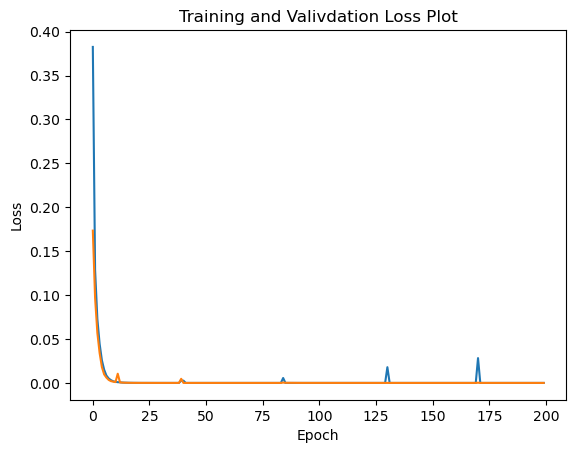

In [16]:
# Plots the training and validation loss curves
plt.title('Training and Valivdation Loss Plot')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.show()

# Training and Validation Accuracy

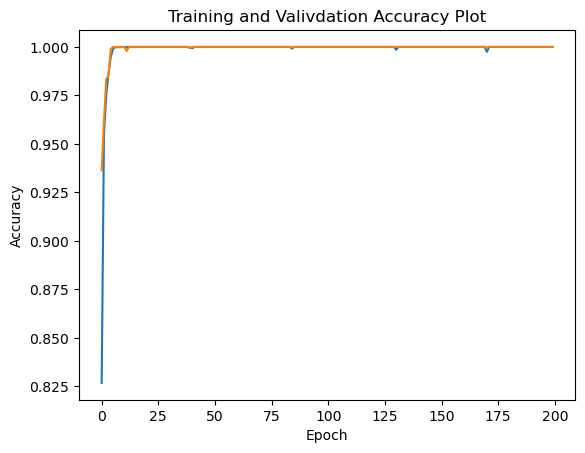

In [17]:
# Plots the training and validation accuracy curves
plt.title('Training and Valivdation Accuracy Plot')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.plot(train_accuracy, label='Train Accuracy')
plt.plot(val_accuracy, label='Val Accuracy')
plt.show()

# Print out all the Python Variables from the Jupyter Notebook to the Screen

In [18]:
# Prints out all the Python variables to the screen
%whos

Variable                Type          Data/Info
-----------------------------------------------
CSVDataset              type          <class '__main__.CSVDataset'>
ConfusionMatrix         ABCMeta       <class 'torchmetrics.clas<...>_matrix.ConfusionMatrix'>
DataLoader              type          <class 'torch.utils.data.dataloader.DataLoader'>
Dataset                 type          <class 'torch.utils.data.dataset.Dataset'>
FNN                     type          <class '__main__.FNN'>
X                       ndarray       23436x4: 93744 elems, type `float64`, 749952 bytes (732.375 kb)
X_batch                 Tensor        tensor([[-0.8419, -0.1794<...>5035, -1.1798, -1.2946]])
acc                     Tensor        tensor(1.)
accuracy                function      <function accuracy at 0x7d0fd60ab7e0>
batch_size              int           32
classification_report   function      <function classification_<...>report at 0x7d0fd9d86480>
dataset                 CSVDataset    <__main__.CSVDatase